In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#for Data Augmentation
import random
import cv2
import glob
import PIL.ImageOps

In [ ]:
# paths for (labeled) training & validation data.
train_path = '/content/drive/MyDrive/FashionClassification/Train/'
valid_path = '/content/drive/MyDrive/FashionClassification/Validation/'

In [ ]:
#Data Augmentation
classes = ['Resort', 'Retro', 'Sporty']
for i, d in enumerate(classes):
    file_path = '/content/drive/MyDrive/FashionClassification/Train/'+d+'/'
    file_names = os.listdir(file_path)
    total_origin_image_num = len(file_names)
    augment_cnt = 1

    for i in range(2000):
        change_picture_index = random.randrange(1, total_origin_image_num-1)
        #print(change_picture_index)
        #print(file_names[change_picture_index])
        file_name = file_names[change_picture_index]

        origin_image_path = '/content/drive/MyDrive/FashionClassification/Train/'+d+'/' + file_name
        image = Image.open(origin_image_path)

        #이미지 좌우 반전
        inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        inverted_image.save(file_path + 'inverted_' + str(augment_cnt) + '.png')

        #이미지 기울이기
        rotated_image = image.rotate(random.randrange(-45, 45))
        rotated_image.save(file_path + 'rotated_' + str(augment_cnt) + '.png')

        
        augment_cnt += 1
print('data augmentation is over')

In [ ]:
# prepare training data set
data =[]
label =[]

## i : Integer representation for each classes (Resort/Retro/Sporty -> 0/1/2)
for i, d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f,'r')
        img = img.resize((150, 150))
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
data.shape, label.shape  # check

((7200, 3, 150, 150), (7200,))

In [ ]:
# prepare validation data set
data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+'/'+d)
    
    for f in files:
        img = Image.open(valid_path+'/'+d+'/'+f,'r')
        img = img.resize((150, 150))
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1)) # (150,150,3) --> (3,150,150)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
data.shape, label.shape  # check

((1800, 3, 150, 150), (1800,))

In [ ]:
# VGG type dict
# int : output chnnels after conv layer
# 'M' : max pooling layer
VGG_types = {
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}

# define VGGnet class
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=3, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, num_classes),

        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)


# creat VGGnet object
model = VGGnet('VGG16', in_channels=3, num_classes=3, init_weights=True)


In [ ]:
# Print the network you built
model.cuda()

VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), 

In [ ]:
# training
def run_train(model, **kwarg):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model, **kwarg):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(),lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        #print('Valid_Prediction : {}'.format(pred))
        #print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
Epoch : 0 /60
Train Accuracy : 41.69444444444444
Validation Accuracy : 43.388888888888886


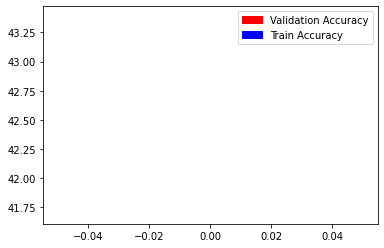

Epoch : 1 /60
Train Accuracy : 49.27777777777778
Validation Accuracy : 50.77777777777778


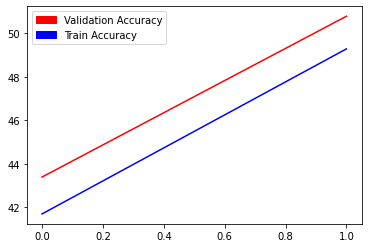

Epoch : 2 /60
Train Accuracy : 52.166666666666664
Validation Accuracy : 49.166666666666664


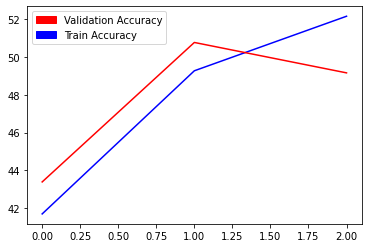

Epoch : 3 /60
Train Accuracy : 52.541666666666664
Validation Accuracy : 53.61111111111111


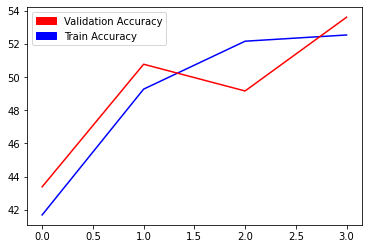

Epoch : 4 /60
Train Accuracy : 54.43055555555556
Validation Accuracy : 54.94444444444444


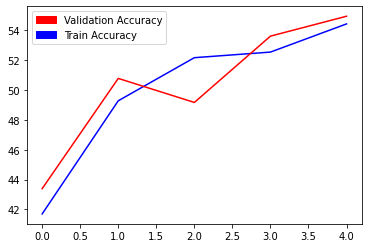

Epoch : 5 /60
Train Accuracy : 55.361111111111114
Validation Accuracy : 53.77777777777778


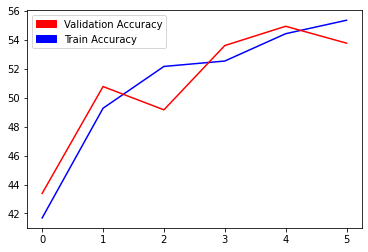

Epoch : 6 /60
Train Accuracy : 57.80555555555556
Validation Accuracy : 43.94444444444445


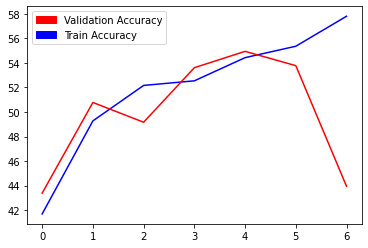

Epoch : 7 /60
Train Accuracy : 61.40277777777777
Validation Accuracy : 60.333333333333336


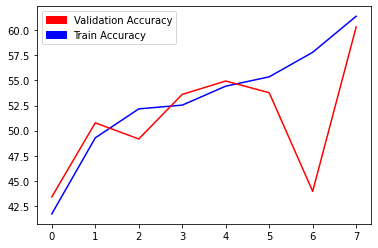

Epoch : 8 /60
Train Accuracy : 65.40277777777777
Validation Accuracy : 63.22222222222222


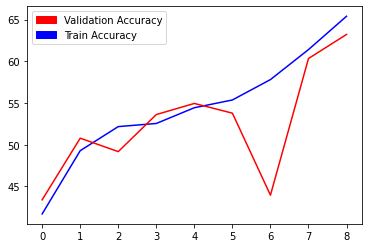

Epoch : 9 /60
Train Accuracy : 67.61111111111111
Validation Accuracy : 66.16666666666666


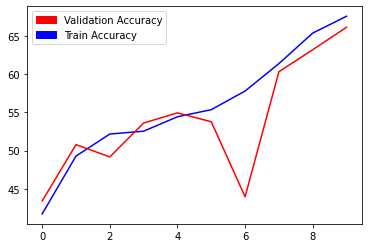

Epoch : 10 /60
Train Accuracy : 70.47222222222223
Validation Accuracy : 66.88888888888889


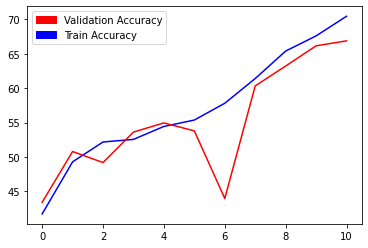

Epoch : 11 /60
Train Accuracy : 72.15277777777777
Validation Accuracy : 68.83333333333333


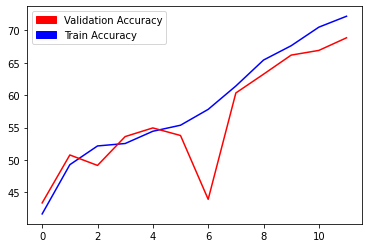

Epoch : 12 /60
Train Accuracy : 73.33333333333333
Validation Accuracy : 63.888888888888886


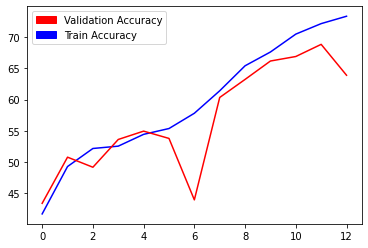

Epoch : 13 /60
Train Accuracy : 76.27777777777777
Validation Accuracy : 64.83333333333333


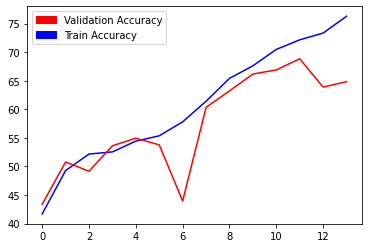

Epoch : 14 /60
Train Accuracy : 77.05555555555556
Validation Accuracy : 68.44444444444444


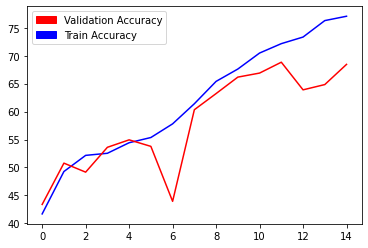

Epoch : 15 /60
Train Accuracy : 79.22222222222223
Validation Accuracy : 69.38888888888889


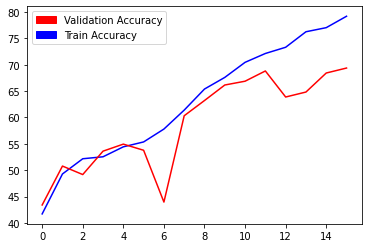

Epoch : 16 /60
Train Accuracy : 80.90277777777779
Validation Accuracy : 69.33333333333334


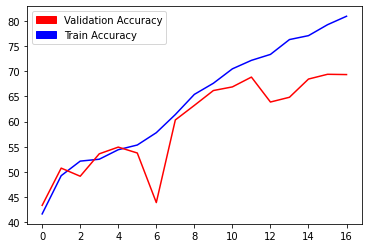

Epoch : 17 /60
Train Accuracy : 82.31944444444444
Validation Accuracy : 59.88888888888889


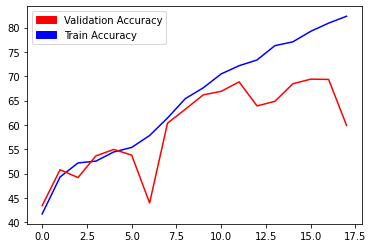

Epoch : 18 /60
Train Accuracy : 84.90277777777779
Validation Accuracy : 70.77777777777777


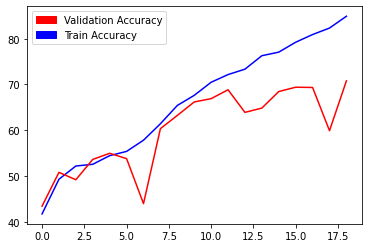

Epoch : 19 /60
Train Accuracy : 86.875
Validation Accuracy : 68.22222222222221


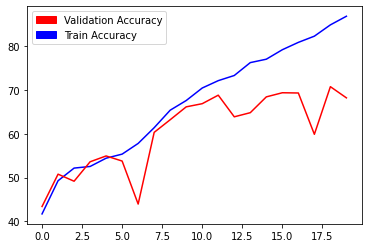

Epoch : 20 /60
Train Accuracy : 87.86111111111111
Validation Accuracy : 71.11111111111111


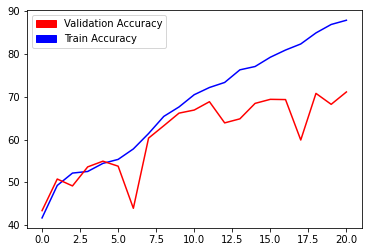

Epoch : 21 /60
Train Accuracy : 88.41666666666667
Validation Accuracy : 68.77777777777779


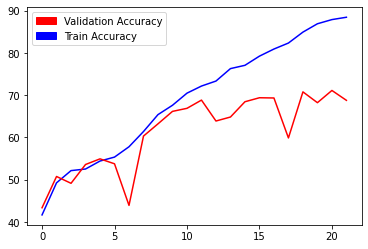

Epoch : 22 /60
Train Accuracy : 89.56944444444444
Validation Accuracy : 69.83333333333334


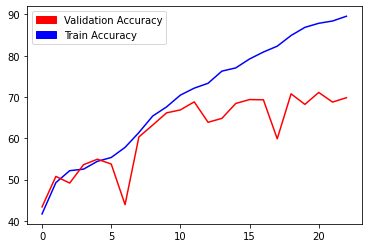

Epoch : 23 /60
Train Accuracy : 90.88888888888889
Validation Accuracy : 65.72222222222223


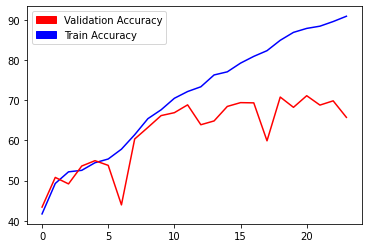

Epoch : 24 /60
Train Accuracy : 91.5
Validation Accuracy : 71.44444444444444


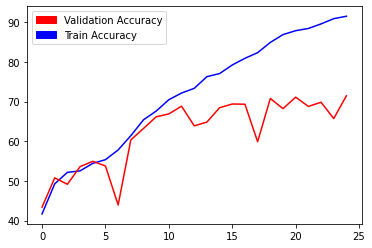

Epoch : 25 /60
Train Accuracy : 91.69444444444444
Validation Accuracy : 69.16666666666667


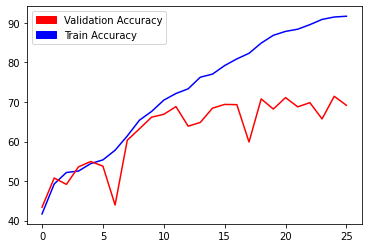

Epoch : 26 /60
Train Accuracy : 91.97222222222223
Validation Accuracy : 68.38888888888889


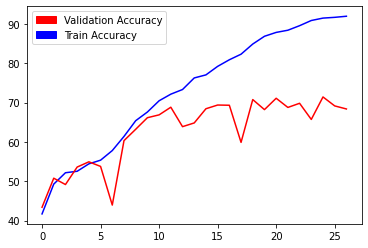

Epoch : 27 /60
Train Accuracy : 93.16666666666666
Validation Accuracy : 71.61111111111111


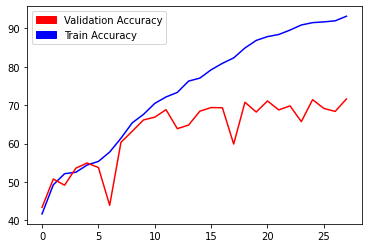

Epoch : 28 /60
Train Accuracy : 92.90277777777777
Validation Accuracy : 69.38888888888889


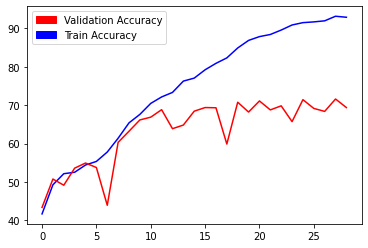

Epoch : 29 /60
Train Accuracy : 93.79166666666666
Validation Accuracy : 68.22222222222221


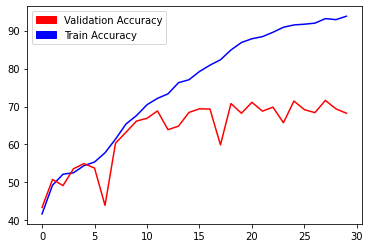

Epoch : 30 /60
Train Accuracy : 93.23611111111111
Validation Accuracy : 69.44444444444444


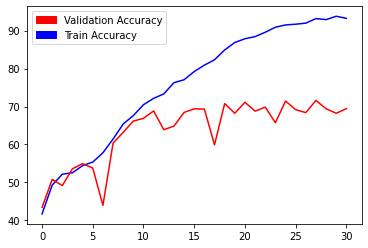

Epoch : 31 /60
Train Accuracy : 94.19444444444444
Validation Accuracy : 67.05555555555556


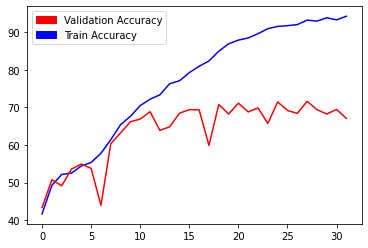

Epoch : 32 /60
Train Accuracy : 94.63888888888889
Validation Accuracy : 65.27777777777779


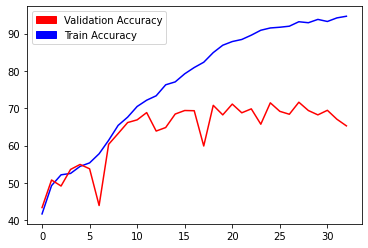

Epoch : 33 /60
Train Accuracy : 94.59722222222223
Validation Accuracy : 68.05555555555556


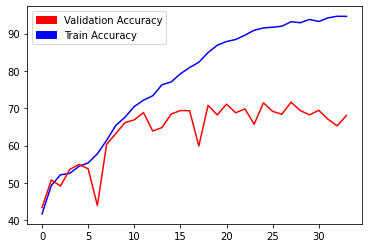

Epoch : 34 /60
Train Accuracy : 94.73611111111111
Validation Accuracy : 71.44444444444444


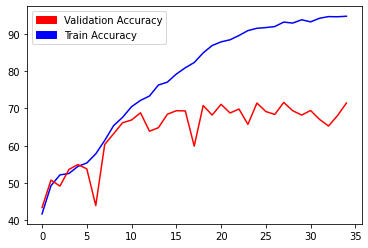

Epoch : 35 /60
Train Accuracy : 95.625
Validation Accuracy : 66.61111111111111


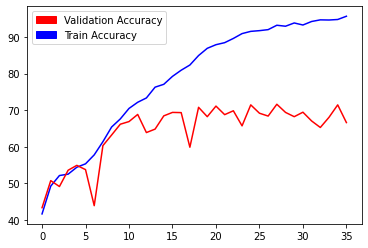

Epoch : 36 /60
Train Accuracy : 95.875
Validation Accuracy : 64.77777777777777


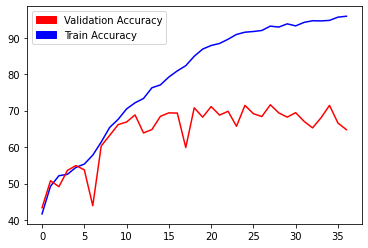

Epoch : 37 /60
Train Accuracy : 95.97222222222223
Validation Accuracy : 70.16666666666667


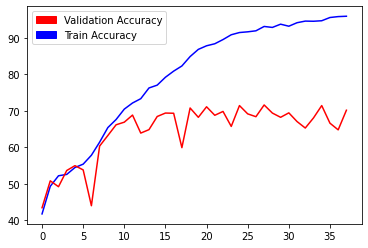

Epoch : 38 /60
Train Accuracy : 95.84722222222221
Validation Accuracy : 72.05555555555556


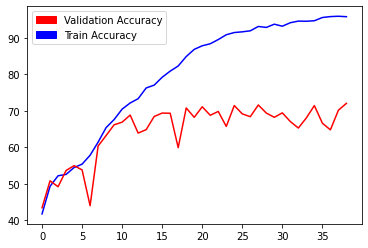

Epoch : 39 /60
Train Accuracy : 95.63888888888889
Validation Accuracy : 68.88888888888889


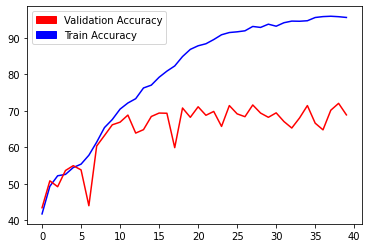

Epoch : 40 /60
Train Accuracy : 95.45833333333333
Validation Accuracy : 69.11111111111111


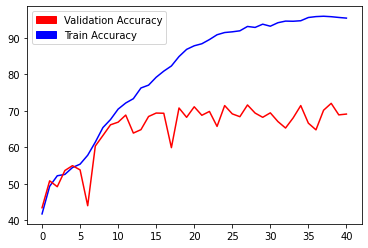

Epoch : 41 /60
Train Accuracy : 96.51388888888889
Validation Accuracy : 73.27777777777777


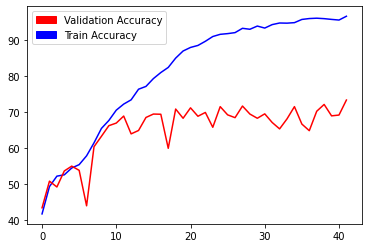

Epoch : 42 /60
Train Accuracy : 96.36111111111111
Validation Accuracy : 70.5


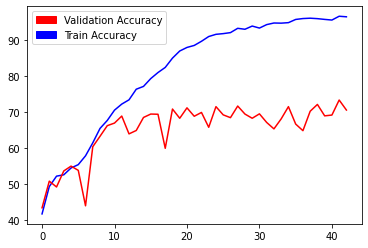

Epoch : 43 /60
Train Accuracy : 95.68055555555556
Validation Accuracy : 72.22222222222221


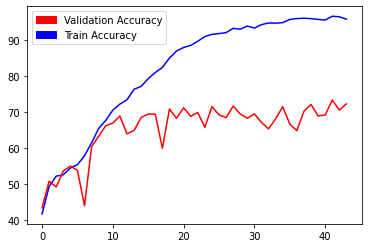

Epoch : 44 /60
Train Accuracy : 95.875
Validation Accuracy : 71.27777777777777


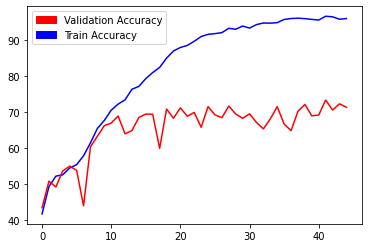

Epoch : 45 /60
Train Accuracy : 96.11111111111111
Validation Accuracy : 70.72222222222221


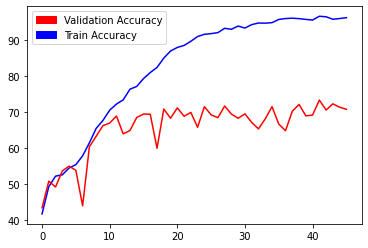

Epoch : 46 /60
Train Accuracy : 95.93055555555556
Validation Accuracy : 69.55555555555556


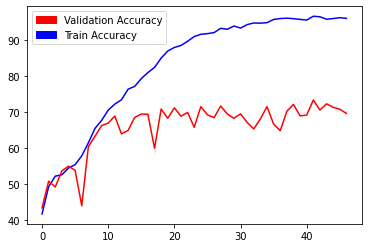

Epoch : 47 /60
Train Accuracy : 96.4861111111111
Validation Accuracy : 72.55555555555556


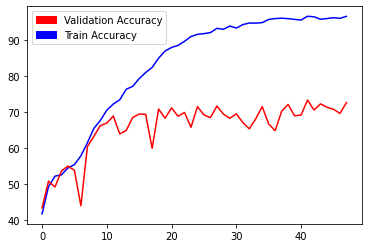

Epoch : 48 /60
Train Accuracy : 95.73611111111111
Validation Accuracy : 72.11111111111111


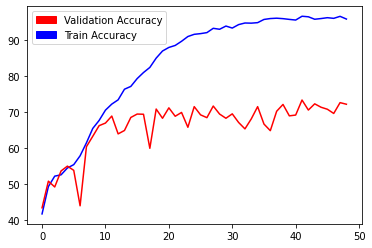

Epoch : 49 /60
Train Accuracy : 96.81944444444444
Validation Accuracy : 70.27777777777777


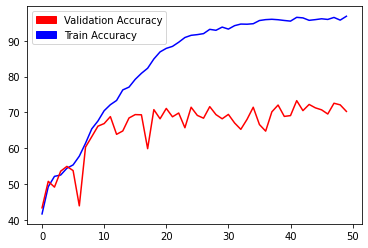

Epoch : 50 /60
Train Accuracy : 96.79166666666667
Validation Accuracy : 72.55555555555556


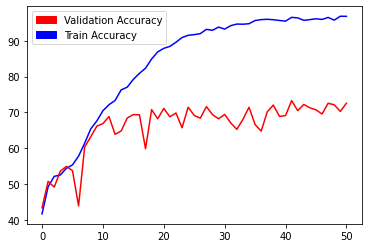

Epoch : 51 /60
Train Accuracy : 96.63888888888889
Validation Accuracy : 71.22222222222221


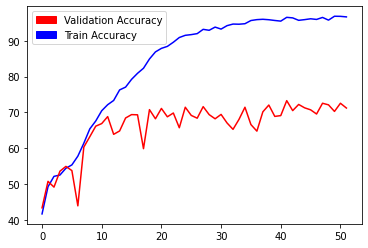

Epoch : 52 /60
Train Accuracy : 96.63888888888889
Validation Accuracy : 68.77777777777779


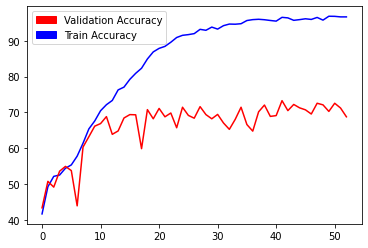

Epoch : 53 /60
Train Accuracy : 96.13888888888889
Validation Accuracy : 67.11111111111111


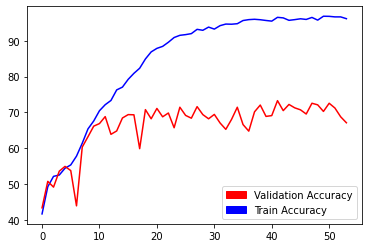

Epoch : 54 /60
Train Accuracy : 96.9861111111111
Validation Accuracy : 71.66666666666667


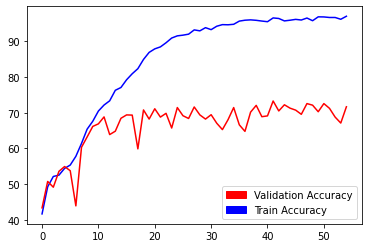

Epoch : 55 /60
Train Accuracy : 96.72222222222221
Validation Accuracy : 71.44444444444444


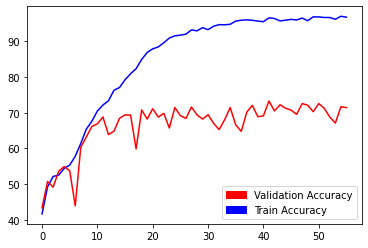

Epoch : 56 /60
Train Accuracy : 97.18055555555556
Validation Accuracy : 72.72222222222223


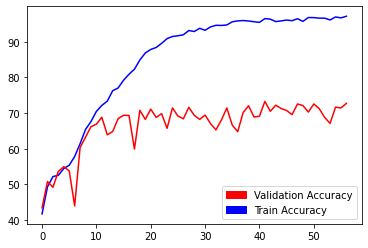

Epoch : 57 /60
Train Accuracy : 97.4861111111111
Validation Accuracy : 70.27777777777777


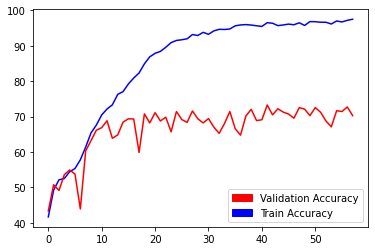

Epoch : 58 /60
Train Accuracy : 97.31944444444444
Validation Accuracy : 65.83333333333333


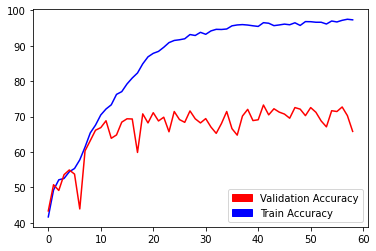

Epoch : 59 /60
Train Accuracy : 96.875
Validation Accuracy : 71.77777777777777


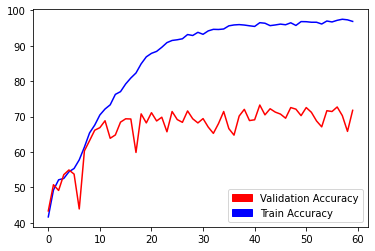

In [ ]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(200):
    print('Epoch : {} /200'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%6 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/MyDrive/FashionClassification/Model_TeamC.pt')